In [ ]:
## in datahub, need to install packages. 
## Need to let support know that the package is needed (if not already on system - try first), 
## they make is available in the system and then you can install with the following command 
## at the top of your notebook

!pip install obspy

## This notebook explores Bokeh for interactive visualizations
### Another package to try is iPyWidgets. A third, non-jupyter notebook option is tkinter

In [1]:
import matplotlib.pyplot as plt

import pandas as pd

import pyproj  # for maps

from obspy.clients.fdsn import Client
from obspy import UTCDateTime
from obspy.geodetics import gps2dist_azimuth

## Datahub has version 2.2.1 of Bokeh
## On my computer, I can only upgrade as far as 1.4.0 without breaking the rest of my environment
## I highly recommend creating a new python environment before installing bokeh on your machine
## one of bokeh's problem child dependencies is tornado, whose version also affects Jupyter functionality
from bokeh.layouts import gridplot, column
from bokeh.models import RangeTool, map_plots, HoverTool, ColumnDataSource
from bokeh.plotting import figure, output_notebook, show
from bokeh.tile_providers import get_provider, Vendors

## Define parameters in this cell:
you might recognize the data retreival cells from the Wk01 notebook...

In [86]:
## Napa M6.0 - 2014-08-24 10:20:44.070
## https://earthquake.usgs.gov/earthquakes/eventpage/nc72282711/executive
evnm = 'Napa M6.0'
t0 = UTCDateTime('2014-08-24T10:20:44.070')   ## origin time
t1 = UTCDateTime('2014-08-24T10:24:44.070')   ## end time for waveforms
evla = 38.215
evlo = -122.312

Xkm = 500   ## MAX distance of stations to download
minplotmeters = 0  ## min and max dist for record section (in METERS)
maxplotmeters = 400000

channel = 'BHZ'

network = 'BK'
client = Client('NCEDC')
#client = Client('IRIS')   ## includes SCSN data

removeresponse = True

### interact with one station's data

/Users/sarinapatel/anaconda3/lib/python3.6/site-packages/obspy/io/stationxml/core.py:84: UserWarning: The StationXML file has version 1.1, ObsPy can deal with version 1.0. Proceed with caution.
  root.attrib["schemaVersion"], SCHEMA_VERSION))


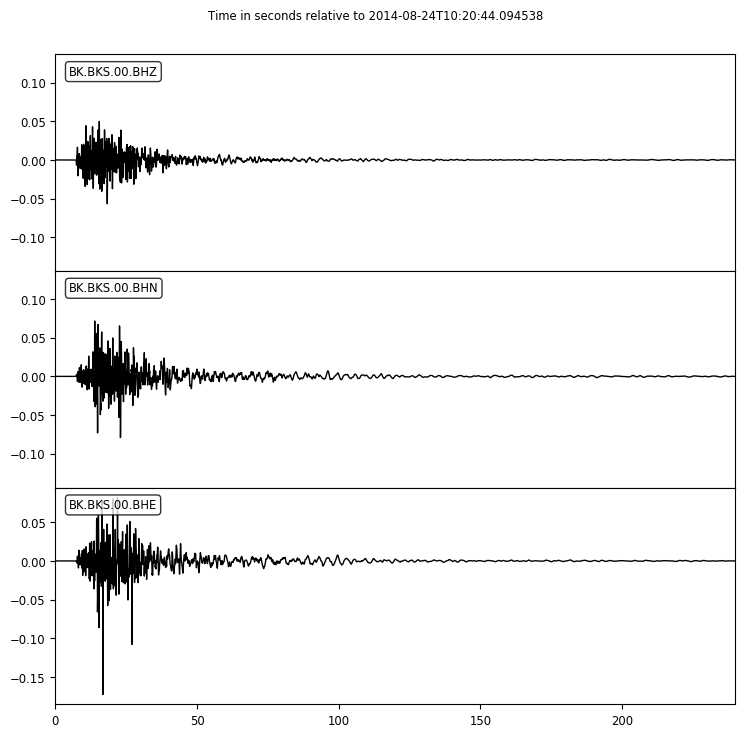

In [96]:
## Pick one station
st = client.get_waveforms(station = 'BKS', \
                          network = network, location = '*', channel = 'BH*', \
                          starttime=t0, endtime=t1, attach_response = True)

## bandpass filter for use with instrument response removal - output in ACC in m/s2, VEL in m/s, DIS in m
bandpass = (0.005, 0.006, 18.0, 20.0)
st.remove_response(output='ACC', pre_filt=bandpass) 

## and plot in obspy to preview
st.plot(type = 'relative')

plt.show()

In [97]:
## now interact with Bokeh

## Specify data
chan = st[1]
x = chan.times()
y = chan.data

## open the plot inline within this notebook
## you can also import output_file and have it export a stable html
output_notebook()

## choose which controls you want
## other tools: https://docs.bokeh.org/en/latest/docs/user_guide/tools.html
Tools = 'pan, box_zoom, hover, reset, save'

## create a new figure with settings
p = figure(title = '%s %s %s' %(chan.stats.station, chan.stats.channel, evnm),
    tools = Tools, plot_height = 300, plot_width = 800,
    y_axis_label = 'Acc (m/s2)',
    x_axis_label = 'Time (sec)', x_range=[0, max(x)])

## add content to figure
p.line(x, y)

## show results
show(p)

Loading BokehJS ...

### pan along with a movable window

In [98]:
## show plot inline within this notebook
output_notebook()

## create figure
## x_range will be the width of your window in seconds, and defines where the window starts
p = figure(plot_height=250, plot_width=800, tools="xpan, hover", toolbar_location=None,
           x_axis_label = 'Time (sec)', x_range=[2, 12],
           y_axis_label = 'Acc (m/s2)')

## add data to figure
p.line(x, y)

## create secondary figure with slider on it
window = figure(title="Drag the middle and edges of the selection box to change the range above",
                tools= "", toolbar_location=None, plot_height=150, plot_width=800,
                y_range=p.y_range, background_fill_color="#efefef")

## create the sliding window to be the width set by p.x_range
range_tool = RangeTool(x_range=p.x_range)
range_tool.overlay.fill_color = "navy"
range_tool.overlay.fill_alpha = 0.2

window.line(x, y)
window.ygrid.grid_line_color = None
window.add_tools(range_tool)
window.toolbar.active_multi = range_tool

show(column(p, window))   # show the plots stacked on top of each other

Loading BokehJS ...

### Map Stations

In [87]:
print_sta_dist_list = False

## get list of stations with metadata
stations = client.get_stations(network = network, starttime=t0, endtime=t1)
#print(stations)

latitudes = []
longitudes = []
stations_in_range = []

for station in stations[0]:
    station_info = station
    stla = station_info.latitude
    stlo = station_info.longitude
    stnm = station_info.code
    
    dist = gps2dist_azimuth(stla, stlo, evla, evlo)[0]/1000.
    
    if dist < Xkm:
        stations_in_range.append(stnm)
        latitudes.append(stla)
        longitudes.append(stlo)
        if print_sta_dist_list:
            print(stnm,' is ',dist,' km from epicenter')

/Users/sarinapatel/anaconda3/lib/python3.6/site-packages/obspy/io/stationxml/core.py:84: UserWarning: The StationXML file has version 1.1, ObsPy can deal with version 1.0. Proceed with caution.
  root.attrib["schemaVersion"], SCHEMA_VERSION))


In [89]:
## convert to Mercator CRS from WGS84 lat longs for the purposes of making a map
## maps are newish in bokeh, and they only support Mercator for now
## EPSG codes here: https://spatialreference.org/
proj_wgs84 = pyproj.Proj(init= "epsg:4326")
proj_merc = pyproj.Proj(init= "epsg:3785")

## station coordinates
mlon, mlat = pyproj.transform(proj_wgs84, proj_merc, longitudes, latitudes)
## event coordinates
mevlo, mevla = pyproj.transform(proj_wgs84, proj_merc, evlo, evla)

## create dataframe of stations and their coordinates for map
data = {'stations': stations_in_range,
        'lat': mlat, 
        'lon': mlon}
df = pd.DataFrame(data = data, columns = ['stations', 'lat', 'lon'], index = stations_in_range)

## now turn the dataframe into a bokeh table format
dsource = ColumnDataSource(df)

## show headers of the data, which you will call when you make the figure
df.head(5)

,stations,lat,lon
BDM,BDM,4.572925e+06,-1.356601e+07
BKS,BKS,4.561955e+06,-1.360720e+07
BL67,BL67,4.561771e+06,-1.360805e+07
BL88,BL88,4.562086e+06,-1.360929e+07
BRIB,BRIB,4.567970e+06,-1.359788e+07


In [90]:
## Set variables -------------

## If you want to bound your map manually, you can set x and y boundary values and use them for x and y_range
# x_bound = (-127, -115)
# y_bound = (30, 43)

## Set the size of the figure; if you make this bigger, you can save a higher resolution image
height = 600
width = 700

## choose map background
tiles = get_provider(Vendors.STAMEN_TERRAIN_RETINA)   # Can also use CARTODBPOSITRON. Type Vendors.<Tab key> to see full list

## choose tools
TOOLS = 'reset, save, box_zoom, pan'
## additionally, initiate the hover tool such that you can have complex settings for it
hover = HoverTool()

## the hover tool should show the station name (indicate the column with @ symbol)
hover.tooltips = [('Station', '@stations'),
                  ('Lat', '@lat'),
                  ('Lon', '@lon')]


## Plot -----------------
output_notebook()   # plot the figure inline within the notebook

m = figure(tools = TOOLS,
#            x_range=(x_bound), y_range =(y_bound),
          plot_height = height, plot_width = width,
          y_axis_label = 'latitude', x_axis_label = 'longitude', 
           y_axis_type = 'mercator', x_axis_type = 'mercator')

m.add_tile(tiles) 

m.triangle(x='lon', y='lat', source = dsource, size = 15, alpha = .6, color = 'blue')     # stations

m.circle(x = mevlo, y = mevla, size = 15, color = 'red')      # event epicenter

m.add_tools(hover)

show(m)

Loading BokehJS ...

### choose stations to look at waveform data

In [91]:
## enter station codes as a string; captilization matters
stn1 = 'FARB'
stn2 = 'BDM'
stn3 = 'JRSC'
stn4 = 'MNRC'

slist = [stn1, stn2, stn3, stn4]

selected_stations = ','.join(slist)  ## need comma separated list
print(selected_stations)

FARB,BDM,JRSC,MNRC


In [103]:
## request waveforms for selected stations 
st = client.get_waveforms(network = network, \
                          station = selected_stations, \
                          location = '*', channel=channel, \
                          starttime=t0, endtime=t1, \
                          attach_response = True)

## bandpass filter for use with instrument response removal
bandpass = (0.005, 0.006, 18.0, 20.0)

## removing response is easy; also choose your y-axis
if removeresponse:
    st.remove_response(output='DISP', pre_filt=bandpass)   

## plot individual wavefroms    
#st.plot(projection="local")

## calc and store epicentral distance for each waveform
for tr in st:
    stnm = tr.stats.station
    station_info = stations.select(station = stnm)[0][0]
    stla = station_info.latitude
    stlo = station_info.longitude
    dist = gps2dist_azimuth(evla, evlo, stla, stlo)[0]
    # need to define this distance in m
    tr.stats.distance = dist
    print(stnm, round(dist/1000, 2), 'km')

/Users/sarinapatel/anaconda3/lib/python3.6/site-packages/obspy/io/stationxml/core.py:84: UserWarning: The StationXML file has version 1.1, ObsPy can deal with version 1.0. Proceed with caution.
  root.attrib["schemaVersion"], SCHEMA_VERSION))


BDM 48.72 km
FARB 83.44 km
JRSC 90.28 km
MNRC 74.56 km


In [104]:
## Settings -------------

## choose which controls you want
## other tools: https://docs.bokeh.org/en/latest/docs/user_guide/tools.html
Tools = 'pan, reset, tap, box_zoom, hover, save'

## set sizing
height = 300
width = 800

## designate traces for each plot
stn_a = st[0]
stn_b = st[1]
stn_c = st[2]


## Plot ---------------
## open the plot inline within this notebook
## you can also import output_file and have it export a stable html
output_notebook()

## create first figure with settings
a = figure(
    tools = Tools, plot_height = height, plot_width = width,
    title= 'Station 1: %s %s' % (stn_a.stats.station, stn_a.stats.channel),
#     y_axis_label = 'Velocity (m/s)',
    y_axis_label = 'Displacement (cm)',
    x_axis_label = 'Time (sec)', x_range=(0, t1-t0))

## plot the first station's data
a.line(stn_a.times(), stn_a.data*100)    ## converting m to cm for ease of reading the axis

## Create second figure
b = figure(
    tools = Tools, plot_height = height, plot_width = width,
    title= 'Station 1: %s %s' % (stn_b.stats.station, stn_b.stats.channel),
#     y_axis_label = 'Velocity (m/s)',
    y_axis_label = 'Displacement (cm)',
    x_axis_label = 'Time (sec)', x_range=(0, t1-t0))

## plot the second station's data
b.line(stn_b.times(), stn_b.data*100)

## create third figure
c = figure(
    tools = Tools, plot_height = height, plot_width = width,
    title= 'Station 1: %s %s' % (stn_c.stats.station, stn_c.stats.channel),
#     y_axis_label = 'Velocity (m/s)',
    y_axis_label = 'Displacement (cm)',
    x_axis_label = 'Time (sec)', x_range=(0, t1-t0))

## add content to figure
c.line(stn_c.times(), stn_c.data*100)


## show results
show(column(a, b, c))      # orders from top down

Loading BokehJS ...

### For each sesimogram, enter the index numbers for p-wave arrival and peak amplitude

##### p = index for p-wave arrival;      d = the index for absolute maximum displacement

In [106]:
## Station 1:
p1 = 366
d1 = 749

## Station 2:
p2 = 582
d2 = 1440

## Station 3:
p3 = 618
d3 = 1915

### Single Station ML, as a rudimentary example:
ML = log(Amplitude) + 2.56log(Distance) - 1.67

In [108]:
# single station ML
from numpy import log10, log

def ML(A, D):
    ml = log10(abs(A)*1000000) + 2.56*(log10(D/1000)) - 1.67      # convert m to um (disp) and m to km (dist)
    return round(ml, 2)


ML_a = ML(stn_a.data[d1], stn_a.stats.distance)
ML_b = ML(stn_b.data[d2], stn_b.stats.distance)
ML_c = ML(stn_c.data[d3], stn_c.stats.distance)

print(ML_a, ML_b, ML_c)

6.26 6.57 6.69
